<a href="https://colab.research.google.com/github/shrabonbiswas/Shrabon_Biswas/blob/main/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📌 Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# 📌 Step 2: Copy zip from Drive to Colab content
!cp "/content/drive/MyDrive/Research/Dataset/Split/Split.zip" "/content/dataset.zip"


In [ ]:
# 📌 Step 3: Extract ZIP in content
import zipfile
zip_path = "/content/dataset.zip"
extract_dir = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
extract_path = "/content/dataset"
train_dir = f"{extract_path}/train"
val_dir = f"{extract_path}/val"
test_dir = f"{extract_path}/test"

In [ ]:
# Load datasets
img_size = (224, 224)
batch_size = 32

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)

Found 4200 files belonging to 4 classes.
Found 900 files belonging to 4 classes.
Found 900 files belonging to 4 classes.


In [ ]:
# Extract class names
class_names = train_ds_raw.class_names
num_classes = len(class_names)

In [ ]:
import tensorflow as tf
# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
# Build Model
base_model = EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)
base_model.trainable = False
# train classifier only for a few epochs
# then unfreeze last few blocks:
for layer in base_model.layers[-20:]:
    layer.trainable = True

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])


model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def categorical_focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss for one-hot encoded targets (multi-class).
    gamma: focusing parameter
    alpha: class weight balancing factor
    """
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())  # avoid log(0)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow((1 - y_pred), gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=categorical_focal_loss(gamma=2., alpha=0.25),
    metrics=['accuracy']
)


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# Compute Class Weights (using UNPREFETCHED training data)
labels = []
for _, label_batch in train_ds_raw:
    labels.extend(np.argmax(label_batch.numpy(), axis=1))

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Train Model
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

Epoch 1/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 31s 140ms/step - accuracy: 0.3368 - loss: 0.2019 - val_accuracy: 0.5800 - val_loss: 0.1335 - learning_rate: 1.0000e-05
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.5781 - loss: 0.1352 - val_accuracy: 0.7211 - val_loss: 0.0931 - learning_rate: 1.0000e-05
Epoch 3/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.6778 - loss: 0.1035 - val_accuracy: 0.7867 - val_loss: 0.0728 - learning_rate: 1.0000e-05
Epoch 4/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.7323 - loss: 0.0848 - val_accuracy: 0.8200 - val_loss: 0.0610 - learning_rate: 1.0000e-05
Epoch 5/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.7749 - loss: 0.0698 - val_accuracy: 0.8322 - val_loss: 0.0533 - learning_rate: 1.0000e-05
Epoch 6/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.8083 - loss: 0.0608 - val_accuracy: 0.8389 - val_loss: 0.0476 - learning_rate: 1.0000e-05
Epoch 7/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 11

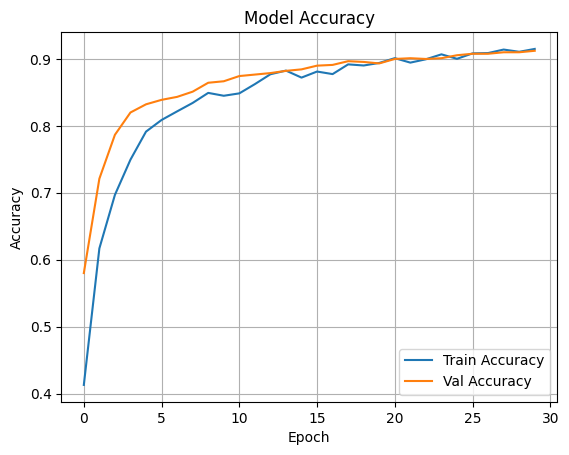

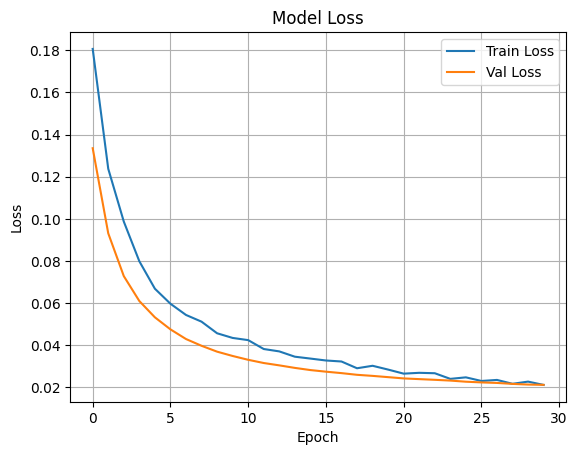

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get true labels from test set
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_true_labels = np.argmax(y_true, axis=1)

# Predict using model
y_pred_probs = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step
Classification Report:

                precision    recall  f1-score   support

        Blight       0.83      0.93      0.87       225
   Common_Rust       0.97      0.97      0.97       225
Gray_Leaf_Spot       0.92      0.81      0.86       225
       Healthy       1.00      0.99      0.99       225

      accuracy                           0.92       900
     macro avg       0.93      0.92      0.92       900
  weighted avg       0.93      0.92      0.92       900



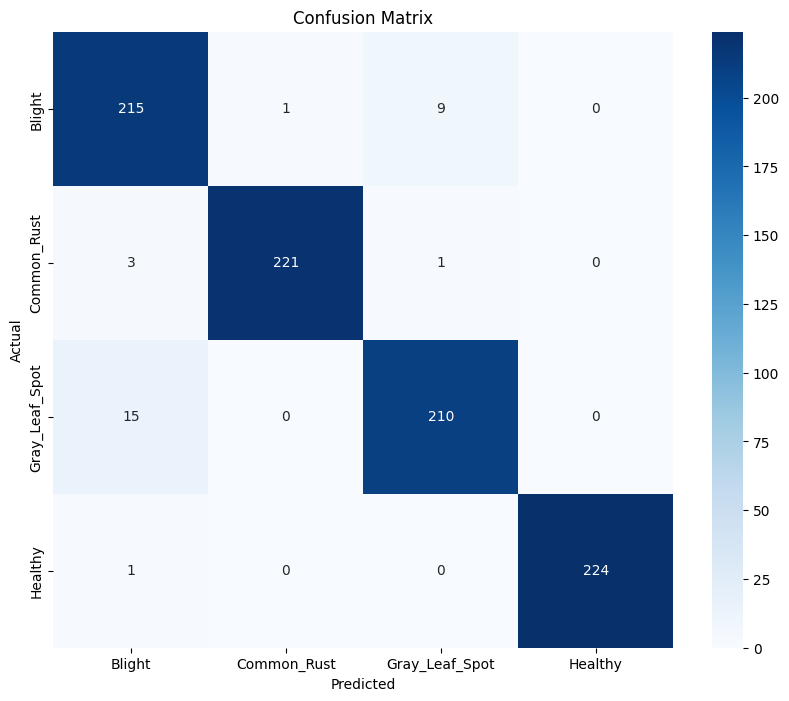

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
model.save("efficientnetb0.keras")  # Saves in Keras format


In [ ]:
import shutil
import os
# ✅ গন্তব্য ডিরেক্টরি (Drive-এ যেখানে রাখতে চাও)
drive_folder = '/content/drive/MyDrive/Research/Dataset/Model'

# গন্তব্য ফোল্ডার যদি না থাকে, তৈরি করো
os.makedirs(drive_folder, exist_ok=True)

# ✅ কপি করো
shutil.copy('/content/efficientnetb0.keras', os.path.join(drive_folder, 'efficientnetb0.keras'))
print(f"✅ Uploaded to Google Drive: {drive_folder}")

✅ Uploaded to Google Drive: /content/drive/MyDrive/Research/Dataset/Model


# VGG16

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ----------------------------
# Dataset Setup
# ----------------------------
img_size = (224, 224)
batch_size = 32

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/val",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)

# Class names
class_names = train_ds_raw.class_names
num_classes = len(class_names)

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

# ----------------------------
# Compute Class Weights
# ----------------------------
labels = []
for _, label_batch in train_ds_raw:
    labels.extend(np.argmax(label_batch.numpy(), axis=1))

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)
class_weight_dict = dict(enumerate(class_weights))

# Optionally boost tricky classes (Blight=0, Gray_Leaf_Spot=2)
class_weight_dict[0] *= 1.5
class_weight_dict[2] *= 1.5

# ----------------------------
# Custom Categorical Focal Loss
# ----------------------------
from tensorflow.keras import backend as K

def categorical_focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss for multi-class classification (one-hot encoded labels).
    """
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow((1 - y_pred), gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss

# ----------------------------
# Build Model with VGG16
# ----------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

base_model = VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)
base_model.trainable = False  # First freeze

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=categorical_focal_loss(gamma=2., alpha=0.25),
    metrics=["accuracy"]
)

# ----------------------------
# Training
# ----------------------------
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
]

history_vgg = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

# ----------------------------
# Fine-tuning Step (optional)
# ----------------------------
# Unfreeze some VGG16 layers after initial training
base_model.trainable = True
for layer in base_model.layers[:-4]:  # freeze all but last 4 conv layers
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=categorical_focal_loss(gamma=2., alpha=0.25),
    metrics=["accuracy"]
)

fine_tune_history_vgg = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Found 900 files belonging to 4 classes.
Found 900 files belonging to 4 classes.
Found 900 files belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 362ms/step - accuracy: 0.2603 - loss: 1.9598 - val_accuracy: 0.2367 - val_loss: 1.3225 - learning_rate: 1.0000e-04
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 331ms/step - accuracy: 0.2785 - loss: 1.8810 - val_accuracy: 0.2411 - val_loss: 1.2177 - learning_rate: 1.0000e-04
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 325ms/step - accuracy: 0.2448 - loss: 1.9231 - val_accuracy: 0.2578 - val_loss: 1.1307 - learning_rate: 1.0000e-04
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 285ms/step - accuracy: 0.2586 - loss: 1.8382 - val_accuracy: 0.2689 - val_loss: 1.0485 - learning_rate: 1.0000e-04
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/step - accuracy: 0.2560 - loss: 1.8324 - val_accuracy: 0.2800 - val_loss: 0.9582 - learning_rate: 1.0000e-04
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/

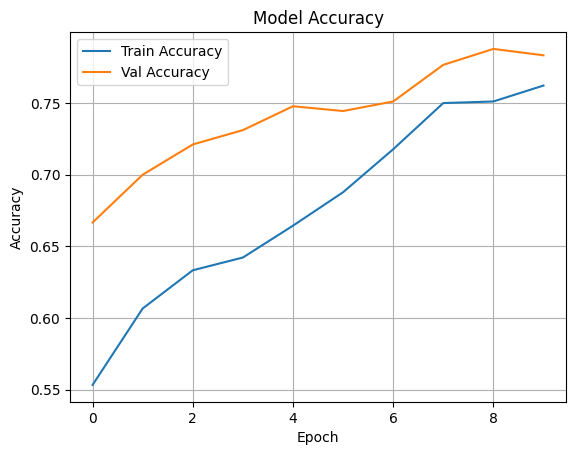

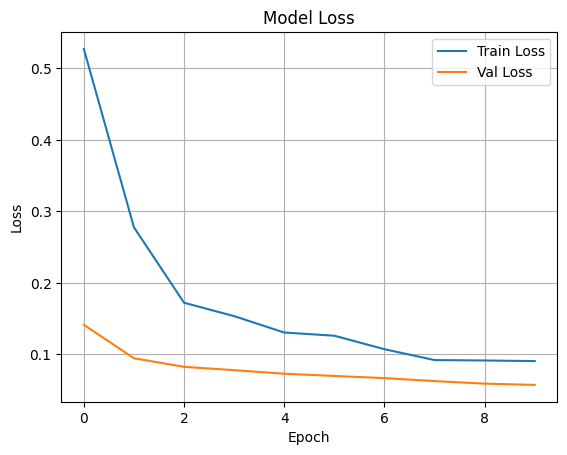

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(fine_tune_history_vgg.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history_vgg.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(fine_tune_history_vgg.history['loss'], label='Train Loss')
plt.plot(fine_tune_history_vgg.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get true labels from test set
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_true_labels = np.argmax(y_true, axis=1)

# Predict using model
y_pred_probs = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step
Classification Report:

                precision    recall  f1-score   support

        Blight       0.76      0.76      0.76       225
   Common_Rust       0.99      0.88      0.94       225
Gray_Leaf_Spot       0.69      0.79      0.74       225
       Healthy       0.97      0.94      0.95       225

      accuracy                           0.84       900
     macro avg       0.85      0.84      0.85       900
  weighted avg       0.85      0.84      0.85       900



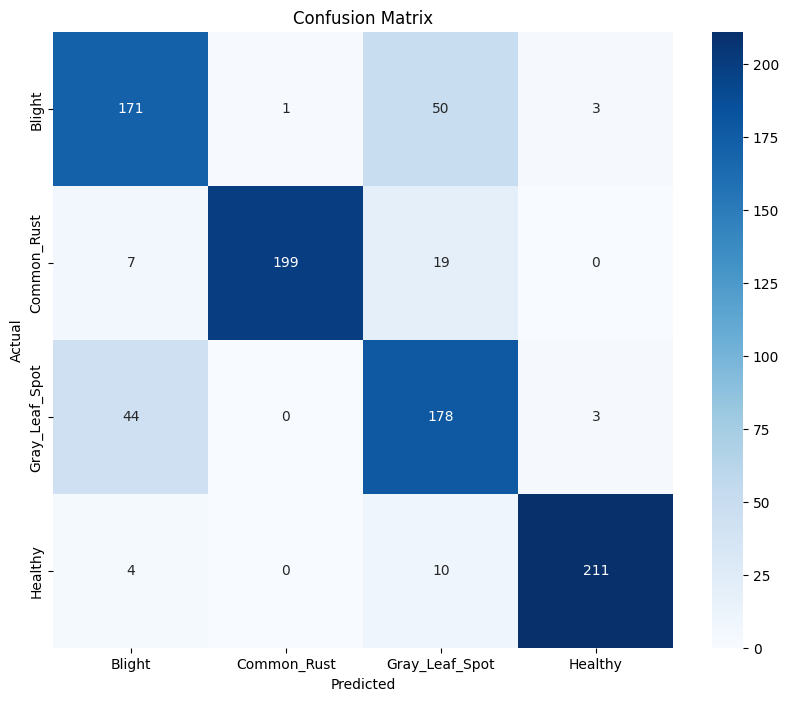

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
